In [1]:
include("../src/ising.jl")
using CairoMakie
using JLD2
import LsqFit as lsq

## simple testing

### create functions to not repeat code

In [2]:
function autocorr_fit(t, p)
    return p[1] .* exp.(-t ./ abs(p[2]))
end

autocorr_fit (generic function with 1 method)

In [3]:
function plot_energy_mag(nrg, mag)
    fig = Figure(size = (1000, 400))
    ax1 = Axis(fig[1, 1], title = "Energy", xlabel = "Step", ylabel = "Energy")
    ax2 = Axis(fig[1, 2], title = "Magnetization", xlabel = "Step", ylabel = "Magnetization")
    lines!(ax1, nrg, color = :blue)
    lines!(ax2, abs.(mag), color = :red)
    return fig
end

plot_energy_mag (generic function with 1 method)

In [4]:
function plot_autocorr(nrg, N_Thermalize::Int=50_000, max_lag::Int=1_000)
    aco = autocorr(nrg[N_Thermalize:end], max_lag=max_lag)
    t = collect(1:max_lag)
    fit = lsq.curve_fit(autocorr_fit, t, aco, [1., 1.])
    print("Tau: ", abs(fit.param[2]))
    
    fig = Figure()
    ax = Axis(fig[1, 1])
    plot!(ax, t, aco, label="Energy Autocorrelation")
    lines!(ax, t, autocorr_fit(t, fit.param), label="Fit", color=:red)
    axislegend(ax)
    return fig
end

plot_autocorr (generic function with 3 methods)

### metropolis

In [5]:
grid_size = 10
T = 5.0
simple_monte_carlo(grid_size=grid_size, T=T, N=1, mc_algorithm=metropolis_step);

In [6]:
@time m_nrg, m_mag = simple_monte_carlo(grid_size=grid_size, T=T, N=500_000, mc_algorithm=metropolis_step);

  0.075464 seconds (63 allocations: 7.661 MiB, 34.99% gc time, 17.80% compilation time)


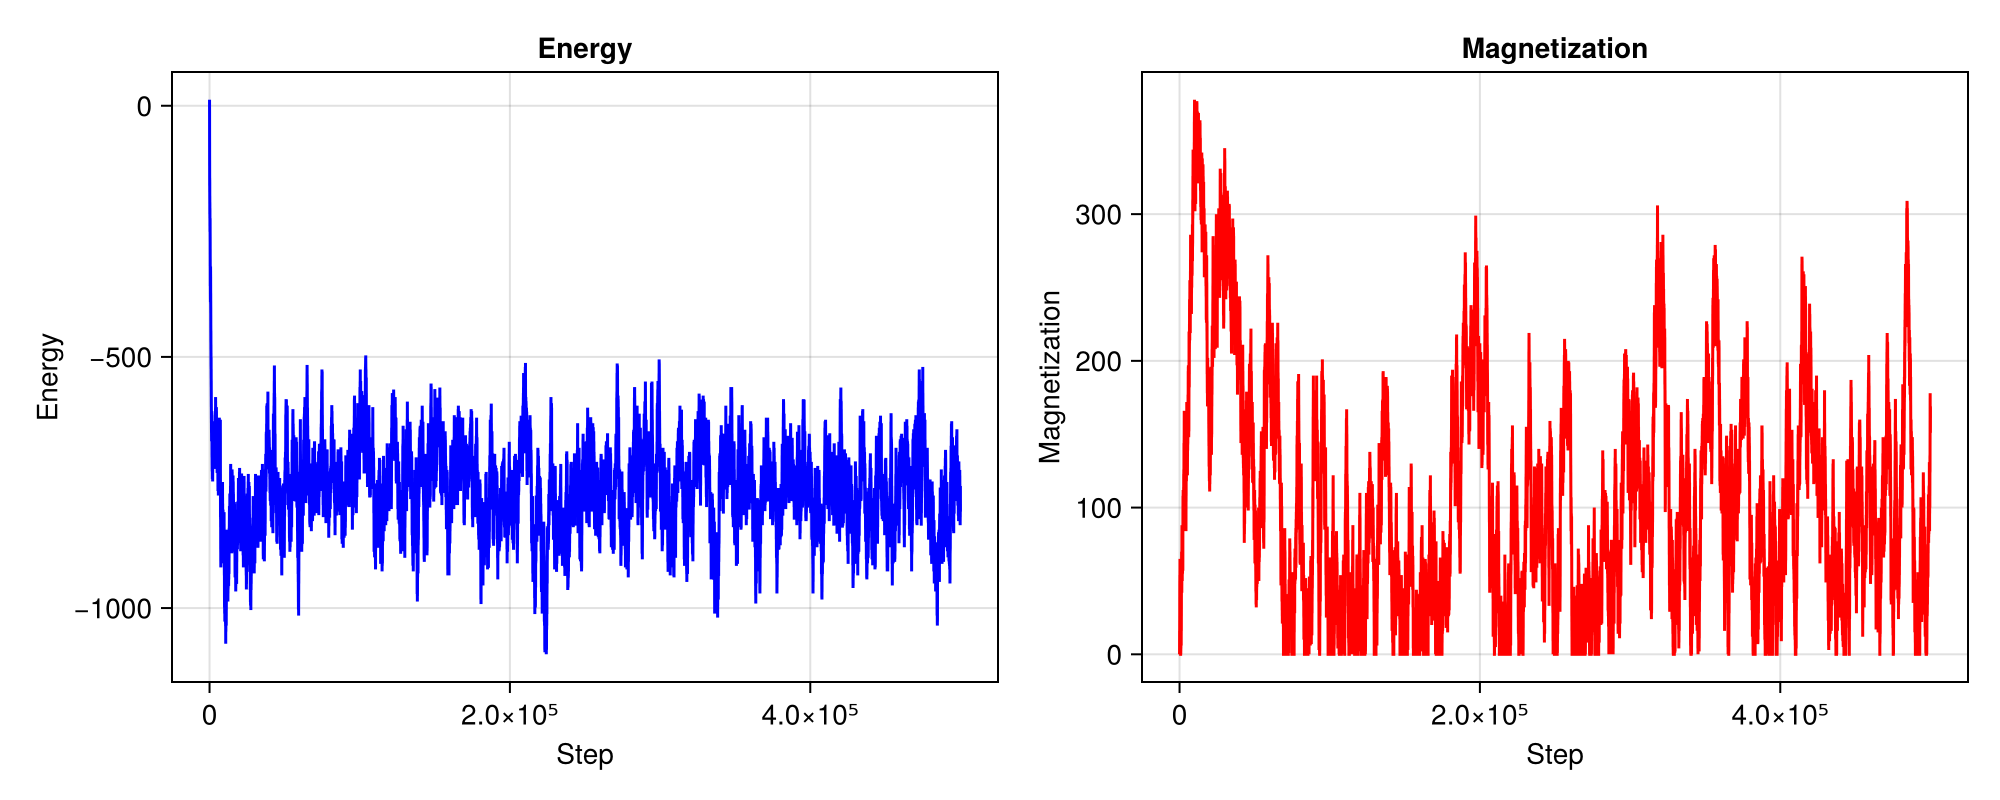

In [7]:
plot_energy_mag(m_nrg, m_mag)

Tau: 1730.5750661156005

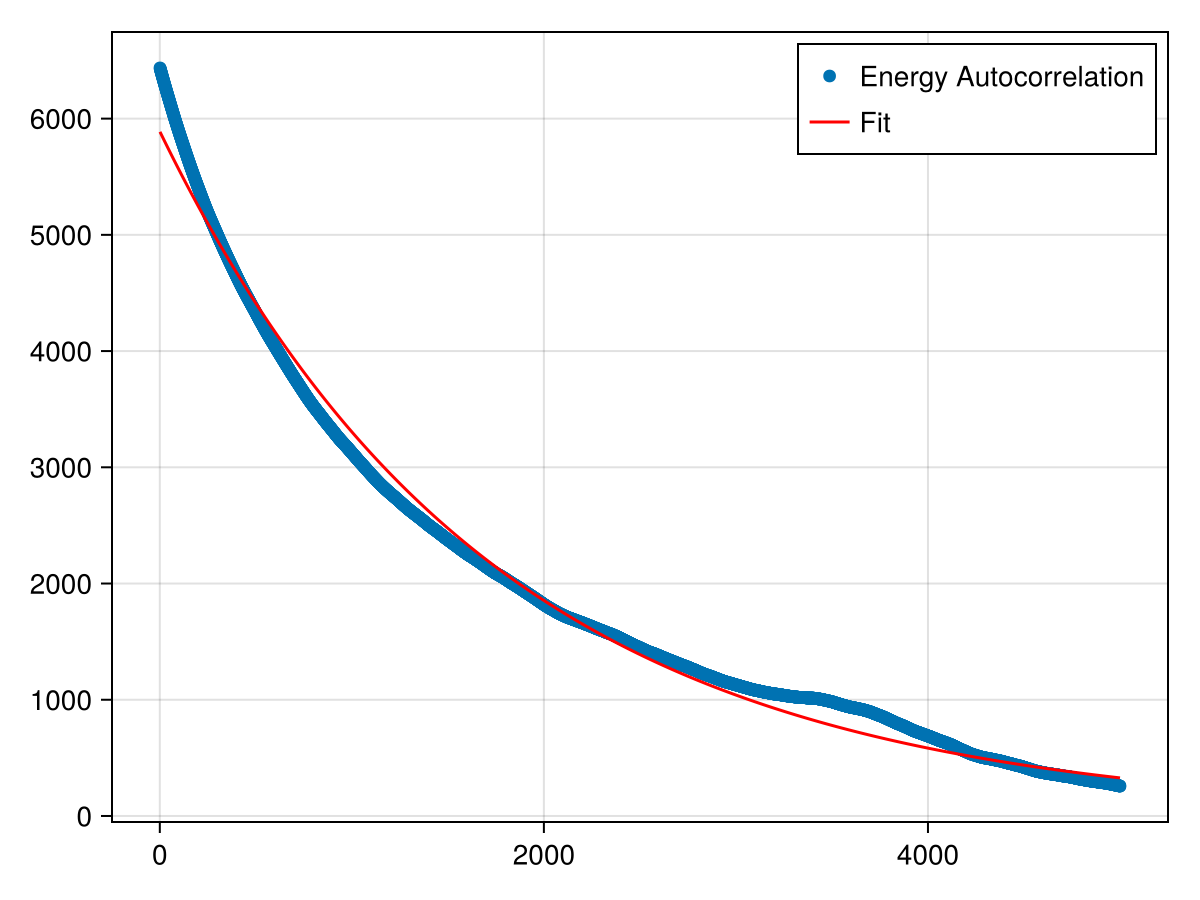

In [8]:
plot_autocorr(m_nrg, 50_000, 5_000)

### Wolff

In [9]:
simple_monte_carlo(grid_size=grid_size, T=T, N=1, mc_algorithm=wolff_step);

In [10]:
@time w_nrg, w_mag = simple_monte_carlo(grid_size=grid_size, T=T, N=10_000, mc_algorithm=wolff_step)

  0.152836 seconds (461.63 k allocations: 99.910 MiB, 24.42% gc time)


([-44.0, -88.0, -112.0, -180.0, -184.0, -300.0, -288.0, -284.0, -284.0, -268.0  …  -740.0, -740.0, -740.0, -740.0, -748.0, -760.0, -752.0, -752.0, -760.0, -772.0], [-20.054, 5.9460000000000015, -12.053999999999998, -100.054, -98.054, -144.054, -142.054, -140.054, -136.054, -124.054  …  13.946000000000026, 11.946000000000026, 9.946000000000026, 3.9460000000000264, 1.9460000000000264, -10.053999999999974, -28.053999999999974, -32.053999999999974, -44.053999999999974, -54.053999999999974])

much less steps are needed to reach equilibrium. the runtime is slower but the number of steps isn't really comparable, because the wolff algorithm flips a lot more spins per step.

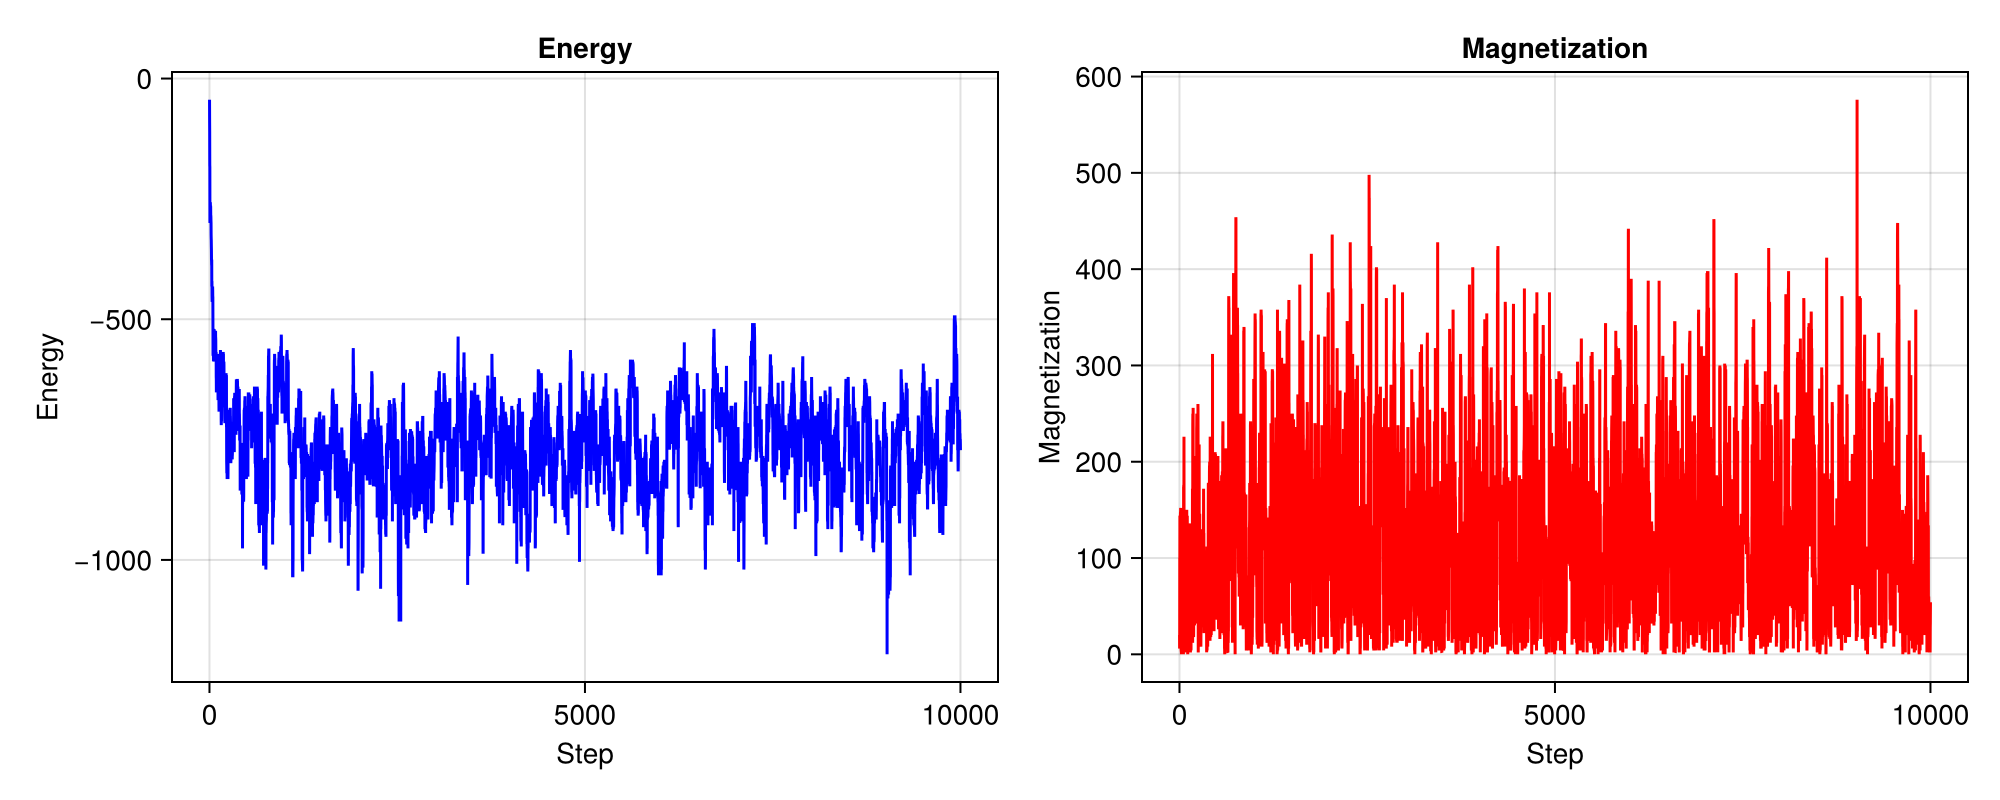

In [11]:
plot_energy_mag(w_nrg, w_mag)

Tau: 24.67333387900184

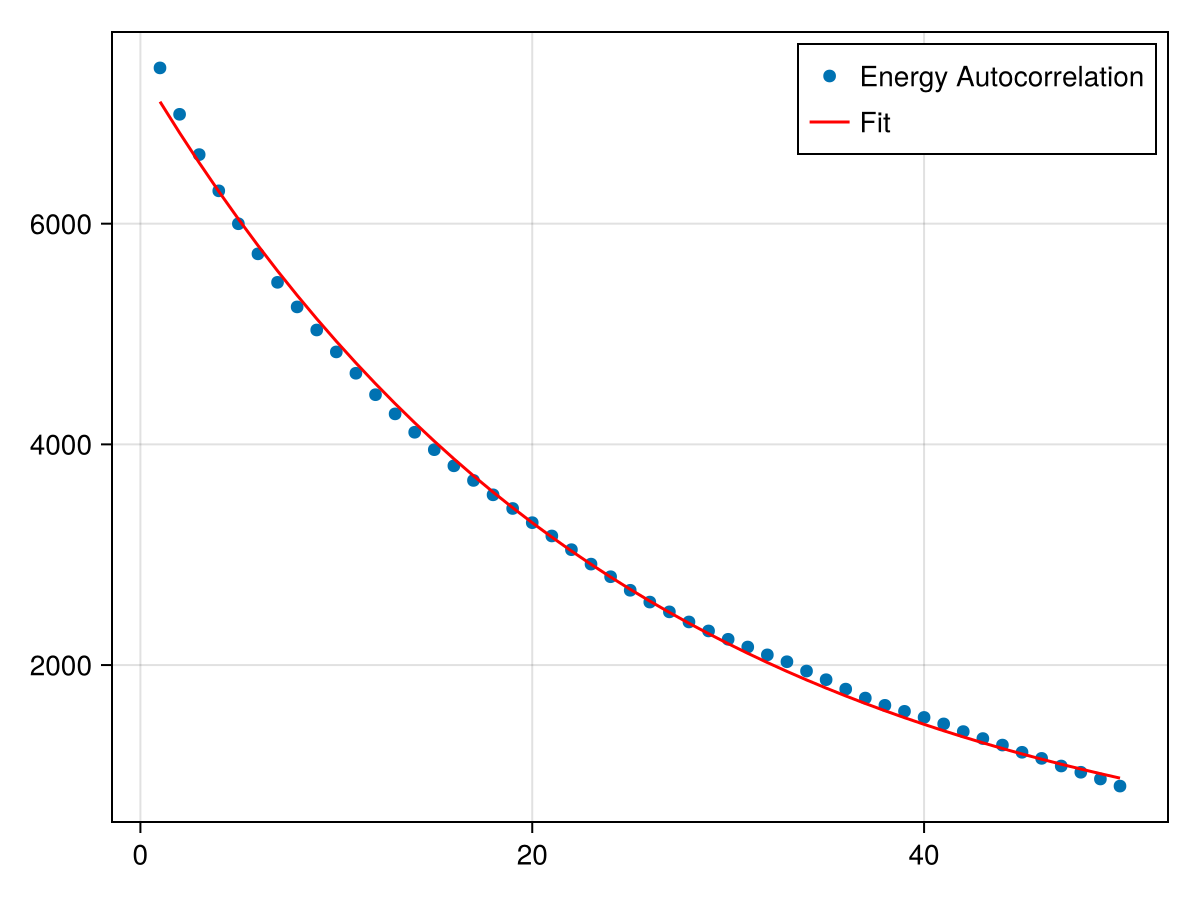

In [12]:
plot_autocorr(w_nrg, 1_000, 50)

the autocorrelation time is much smaller

**TODO:** gather data with a single function and create Table